# Módulos

In [1]:
import os # Arquivos

import numpy as np # Matrizes
import pandas as pd # Tabelas

import matplotlib.pyplot as plt # Gráficos

import multiprocessing as mp # Magia negra (paralelização)

from sklearn.feature_extraction.text import CountVectorizer # Tokenização.
from sklearn.decomposition import LatentDirichletAllocation # Latent Dirichlet Allocatoin.

from sklearn.model_selection import RandomizedSearchCV, KFold # Otimização de hiperparâmetros.

from scipy.stats import randint, loguniform, uniform, norm, reciprocal # Distribuições dos parâmetros.

from time import perf_counter # Cronômetro

# Funções

## Avaliação do modelo

In [2]:
def estimar_perplexidades_com_KFold(corpus, 
                                    learning_method, 
                                    n_components, 
                                    doc_topic_prior, topic_word_prior,
                                    learning_decay, learning_offset, batch_size,
                                    n_splits, random_state, n_jobs):
    
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = random_state)

    modelos, resultados = [], []
    for iteração, (índices_de_treino, índices_de_teste) in enumerate(kf.split(corpus)):

        # Iteração
        iteração += 1
        print(f'K{iteração}')
        início = perf_counter()

        # Divisão entre treino e teste
        corpus_de_treino, corpus_de_teste = corpus[índices_de_treino], corpus[índices_de_teste]

        # Latent Dirichlet Allocation
        modelo_de_LDA = LatentDirichletAllocation(n_components = n_components, 
                                                  learning_method = learning_method, 
                                                  doc_topic_prior = doc_topic_prior, topic_word_prior = topic_word_prior,
                                                  learning_decay = learning_decay, learning_offset = learning_offset, batch_size = batch_size,
                                                  random_state = random_state, n_jobs = n_jobs)
        modelo_de_LDA.fit(corpus_de_treino)
        modelos.append(modelo_de_LDA)

        # Perplexidade e score do modelo 
        perplexidade, pontuação = modelo_de_LDA.perplexity(corpus_de_teste), modelo_de_LDA.score(corpus_de_teste)
        
        print('>>> Perplexidade:', round(perplexidade,2))
        print('>>> Pontuação:', round(pontuação,2),'\n')
        
        resultados.append([iteração, perplexidade, pontuação])

        fim = perf_counter()
        minutos, segundos = divmod(fim-início, 60)
        print(f'Tempo decorrido: {int(minutos)}m{int(segundos):02d}s..!\n')

    # Output, enfim
    return modelos, resultados

## Cenários simulados

In [3]:
def simular_parâmetros(número_de_simulações, distribuições, random_state = 1):
    
    rng = np.random.RandomState(random_state) # Gerador pseudoaleatório compartilhado por todos os parâmetros.
    dados = [{parâmetro: distribuição.rvs(size = 1, random_state = rng)[0] # O rvs o atualiza a cada iteração..!
              for parâmetro, distribuição in distribuições.items()} 
             for _ in range(número_de_simulações)]
    
    df = pd.DataFrame(dados)
    df.n_components *= 10 # Somente quero testar de N em N tópicos. 
    
    return df

# Busca aleatória

## Outros parâmetros

In [4]:
diretório = os.getcwd() 
diretório_anterior = '\\'.join(diretório.split('\\')[:-1])
diretório_dos_corpus = diretório_anterior + '\\' + '1. Coleta e tratamento\\bases para o LDA'

seleção = 'valor' # Um portal de cada vez, e provavelmente só farei para a Valor Econômico.
recorte = 'total' # Manchetes, resumos e 1ºs parágrafos.

learning_method = 'online' # Aqui, somente avaliaremos com o OVB.
n_splits = 4 # 75% de treino contra 25% de teste.
n_jobs = mp.cpu_count() # Todas as CPUs..!

## Simulações

In [5]:
distribuições = {'valor': {'n_components': randint(2, 7+1), # 20, 30, 40, 50, 60 ou 70;
                           'learning_decay': uniform(0.6, 0.3), # Entre 0.6 e 0.9;
                           'learning_offset': randint(1, 1000)}, # De 1k a 10k.
                
                 'globorural': {'n_components': randint(1, 6+1), # 10, 20, 30, 40, 50 ou 60;
                                'learning_decay': uniform(0.6, 0.3), # Entre 0.6 e 0.9;
                                'learning_offset': randint(1, 1000)}, # De 1k a 10k.

                 'epocanegocios': {'n_components': randint(2, 7+1), # 20, 30, 40, 50, 60 ou 70;
                                   'learning_decay': uniform(0.6, 0.3), # Entre 0.6 e 0.9;
                                   'learning_offset': randint(1, 1000)}, # De 1k a 10k.

                 'valorinveste': {'n_components': randint(2, 7+1), # 20, 30, 40, 50, 60 ou 70;
                                  'learning_decay': uniform(0.6, 0.3), # Entre 0.6 e 0.9;
                                  'learning_offset': randint(1, 1000)},
                 
                 'revistapegn': {'n_components': randint(1, 6+1), # 10, 20, 30, 40, 50 ou 60;
                                 'learning_decay': uniform(0.6, 0.3), # Entre 0.6 e 0.9;
                                 'learning_offset': randint(1, 1000)}} # De 1k a 10k.

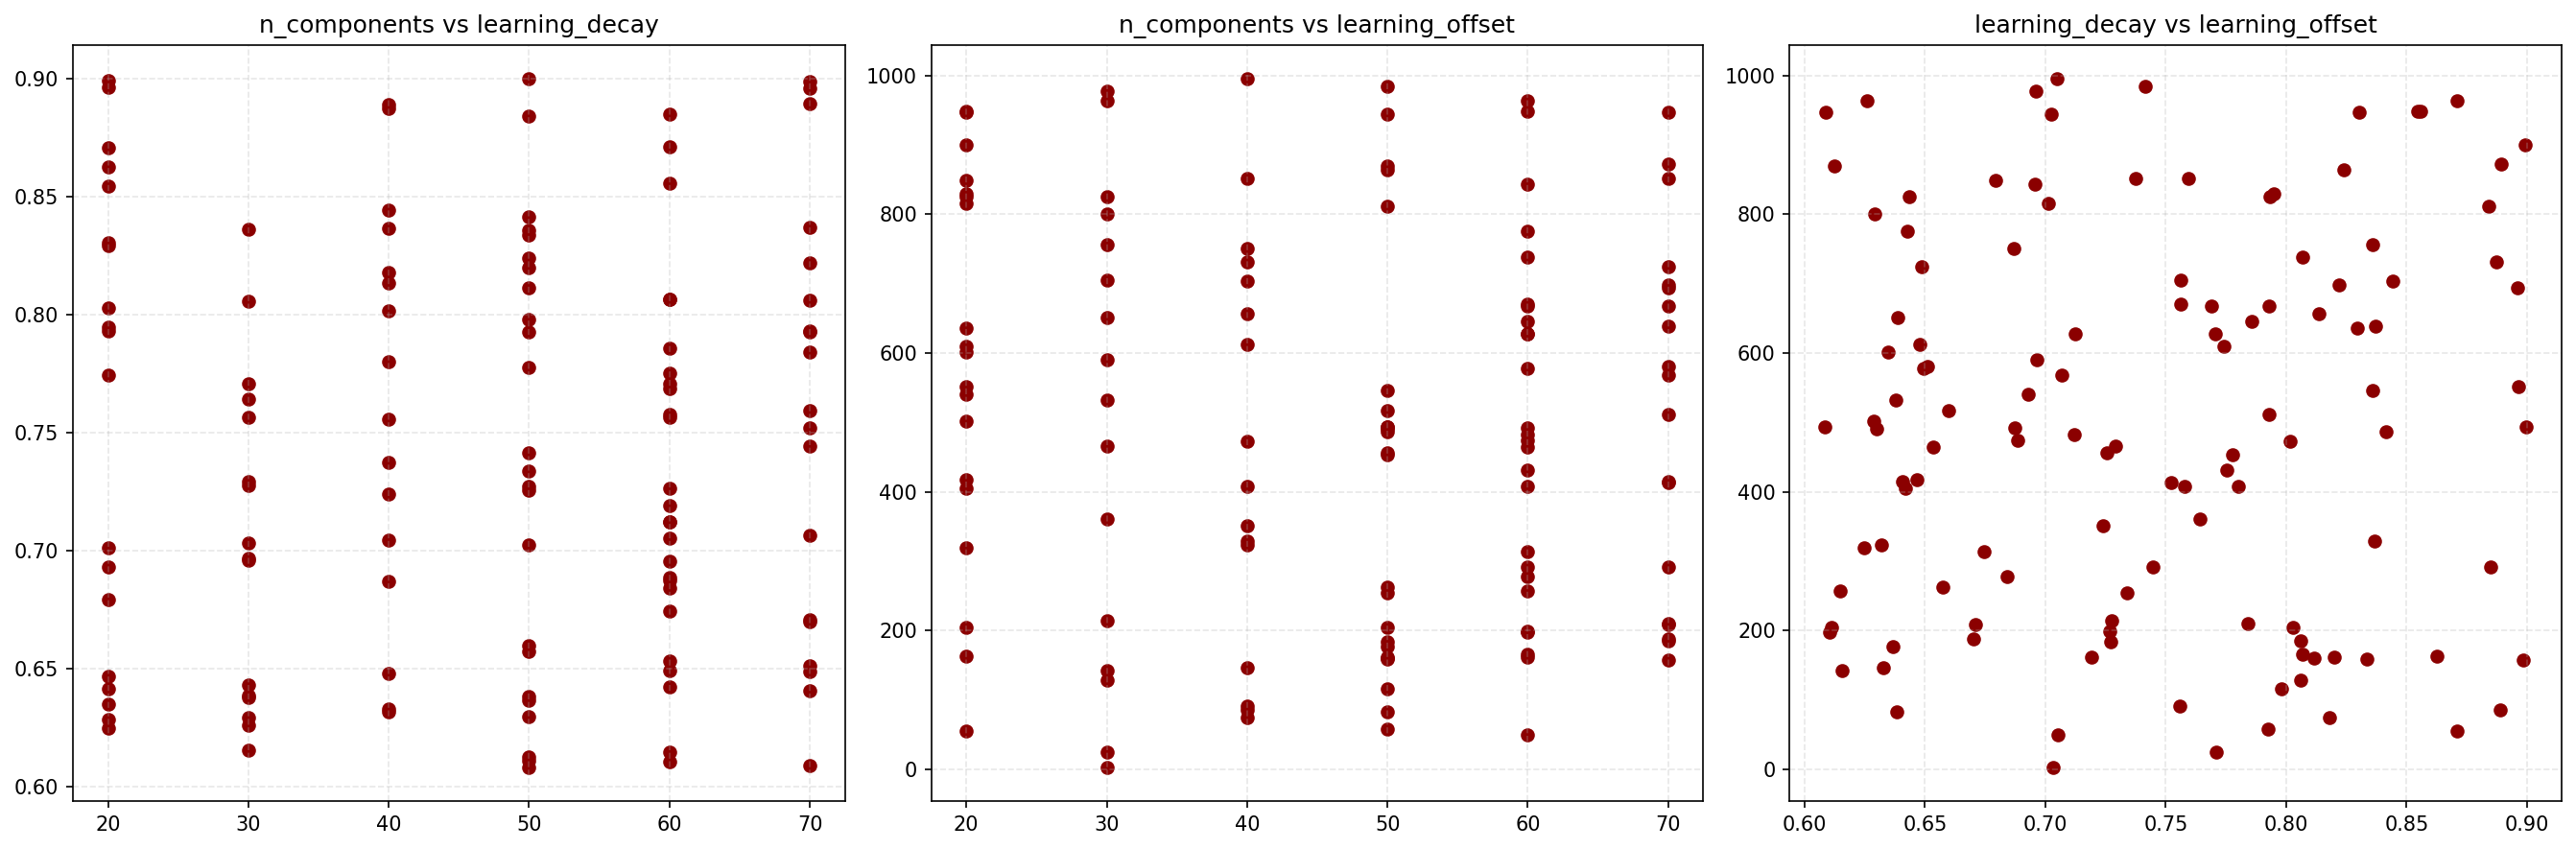

In [6]:
random_state = 12 # Semente aleatória

# Simulações dos parâmetros
simulações = simular_parâmetros(120, distribuições[seleção], random_state)

# Definir pares de colunas para plotagem
variáveis = ['n_components', 'learning_decay', 'learning_offset']
pares = [(0, 1), (0, 2), (1, 2)]
títulos = ['n_components vs learning_decay',
           'n_components vs learning_offset',
           'learning_decay vs learning_offset']

# Criar subplots
fig, axs = plt.subplots(1, 3, figsize = (18, 6), dpi = 150)
for ax, (i, j), título in zip(axs, pares, títulos):
    ax.scatter(simulações[variáveis[i]], simulações[variáveis[j]], 
               color = 'darkred')
    ax.set_title(título)
    ax.grid(True, linestyle = '--', alpha = .3)
plt.tight_layout()
plt.show()

## Parametragem

In [7]:
# Preparação dos dados      
arquivo_do_corpus = f'{seleção} - {recorte}.parquet'
df = pd.read_parquet(diretório_dos_corpus + '\\' + arquivo_do_corpus)
df = df[df.corpus != ''].copy()

vetorizador = CountVectorizer()
corpus = vetorizador.fit_transform(df.corpus)

# Verificação de cada cenário
for iteração, parâmetros in enumerate(simulações.values.tolist()):

    # Parâmetros
    n_components, learning_decay, learning_offset = parâmetros
    n_components = int(n_components) # Este valor deve ser um nº inteiro.
    doc_topic_prior, topic_word_prior = 1/n_components, 1/n_components

    # Histórico
    arquivo = f'{seleção} - {recorte} - simulação nº {iteração+1}.xlsx'
    if arquivo in os.listdir('parametragem'): # Check-point.
        print(f'-----------\nJá lido: {arquivo}..!\n')
        continue

    # Verbose
    print(f'-----------\nLendo: {arquivo}..!\n')
    print(f'n_components: {n_components}')
    print(f'learning_decay: {learning_decay:.3f}')
    print(f'learning_offset: {int(learning_offset)}\n')

    # Parametragem
    n = corpus.shape[0]
    batch_size = max(128, int(n*0.01))
    modelos, resultados = estimar_perplexidades_com_KFold(corpus, 
                                                          learning_method, # Online..!
                                                          n_components, doc_topic_prior, topic_word_prior,
                                                          learning_decay, learning_offset, batch_size,
                                                          n_splits, random_state, n_jobs)

    # Arquivamento na pasta
    resultados = pd.DataFrame(resultados, columns = ['kfold', 'perplexity', 'score'])
    resultados[simulações.columns] = n_components, learning_decay, learning_offset
    resultados['simulation'] = iteração+1
    resultados = resultados[['simulation', 'kfold', 'perplexity', 'score'] + simulações.columns.tolist()].copy()
    resultados.to_excel(f'parametragem/{arquivo}', index = False)

-----------
Já lido: valor - total - simulação nº 1.xlsx..!

-----------
Já lido: valor - total - simulação nº 2.xlsx..!

-----------
Já lido: valor - total - simulação nº 3.xlsx..!

-----------
Já lido: valor - total - simulação nº 4.xlsx..!

-----------
Já lido: valor - total - simulação nº 5.xlsx..!

-----------
Já lido: valor - total - simulação nº 6.xlsx..!

-----------
Já lido: valor - total - simulação nº 7.xlsx..!

-----------
Já lido: valor - total - simulação nº 8.xlsx..!

-----------
Já lido: valor - total - simulação nº 9.xlsx..!

-----------
Já lido: valor - total - simulação nº 10.xlsx..!

-----------
Já lido: valor - total - simulação nº 11.xlsx..!

-----------
Já lido: valor - total - simulação nº 12.xlsx..!

-----------
Já lido: valor - total - simulação nº 13.xlsx..!

-----------
Já lido: valor - total - simulação nº 14.xlsx..!

-----------
Já lido: valor - total - simulação nº 15.xlsx..!

-----------
Já lido: valor - total - simulação nº 16.xlsx..!

-----------
Já li


KeyboardInterrupt

